In [1]:
import os, glob
import fitsio
from scipy.ndimage.filters import gaussian_filter 
from scipy.signal import convolve2d
from scipy.io import readsav
import numpy as np
import matplotlib
#matplotlib.use('tkagg')
import matplotlib.pyplot as plt
from matplotlib import rc
# Load FLCT
from pathlib import Path, PurePath
from IPython.display import display
import time
import pandas as pd


matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12})
matplotlib.rcParams.update({'axes.labelsize': 12})
pd.options.display.max_columns = None

In [2]:
def load_vel_mean(v_files, trange):
    "Load the velocity files and average over a time range"
    vxs = []
    vys = []
    vx_files_subset = v_files[0][trange[0]:trange[1]]
    vy_files_subset = v_files[1][trange[0]:trange[1]]
    for vxf, vyf in zip(vx_files_subset, vy_files_subset):
        vxs.append(fitsio.read(vxf))
        vys.append(fitsio.read(vyf))
    # Get the mean of the velocity components
    vx = np.array(vxs).mean(axis=0)
    vy = np.array(vys).mean(axis=0)
    return np.array([vx, vy])


def smooth_vel(v, fwhm, kernel='boxcar'):
    """ Smooth the velocity with a smoothing kernel that can either be: 
     - boxcar: width set to fwhm
     - gaussian: parametrized by fwhm. 
     
     Returns the smoothed velocity components
    """ 
    
    if fwhm > 1:
        if kernel == 'boxcar':
            box = np.ones([fwhm, fwhm]) / fwhm**2
            vxs2 = convolve2d(v[0,...], box, mode='same')
            vys2 = convolve2d(v[1,...], box, mode='same')
        elif kernel == 'gaussian':
            sigma = fwhm / 2.35
            vxs2 = gaussian_filter(v[0,...], sigma=sigma, order=0)
            vys2 = gaussian_filter(v[1,...], sigma=sigma, order=0)
    else:
        print('smoothing not applied')
        vxs2 = v[0,...]
        vys2 = v[1,...]
                
    vm = np.sqrt(vxs2**2 + vys2**2)
    return np.array([vxs2, vys2, vm])


# For FLCT
def read_vi(file, data_str):
    idl_dict = readsav(file)
    vi = idl_dict[data_str]
    return vi


def calc_c_pearson(vx1, vx2, vy1, vy2, fov=None):
    vx1f, vx2f, vy1f, vy2f = vx1[fov], vx2[fov], vy1[fov], vy2[fov]
    c_pearson = np.sum(vx1f*vx2f + vy1f*vy2f) / np.sqrt(np.sum(vx1f**2 + vy1f**2)*np.sum(vx2f**2 + vy2f**2))
    return c_pearson


In [10]:
datadir = os.path.join(os.environ['DATA'], 'Ben/SteinSDO')

u = 368000 / 60

fwhm = 4
kernel = 'boxcar'
dims = [263, 263]
# Select a subfield excluding edge effects
# Use same padding size as in Tremblay et al. 2018 used trim = 10px for fwhm = 7
pad = fwhm
fov = np.s_[pad:dims[0]-pad:pad, pad:dims[1]-pad:pad]
trange = [0, 30]

In [32]:
# Load Stein data
fwhm2 = 11
svx_files = sorted(glob.glob(os.path.join(datadir,'SDO_vx*.fits')))
svy_files = sorted(glob.glob(os.path.join(datadir,'SDO_vy*.fits')))
#vx, vy = load_vel_mean((svx_files, svy_files), tranges[0])
v_stein = load_vel_mean((svx_files, svy_files), trange) 
# smooth the Stein velocities 
v_stein_sm = smooth_vel(v_stein, fwhm2, kernel=kernel)
#npts_ = v_stein_sm[0][0][fov].size
v_stein_sm_pad = v_stein_sm[:, 0:dims[0]:pad, 0:dims[0]:pad]

v_stein_sm.shape

(3, 263, 263)

In [33]:
# Load DALI flows
dv = np.load('flow_vectors.npy')
dvmean = dv.mean(axis=0)
dvmean = np.moveaxis(dvmean, -1, 0)
dvmean_sm = smooth_vel(dvmean, 1, kernel=kernel)
print(dvmean_sm.shape)
corr = calc_c_pearson(v_stein_sm_pad[0,...], -dvmean_sm[0, ...], v_stein_sm_pad[1, ...], -dvmean_sm[1, ...], fov=fov)
print(corr)

smoothing not applied
(3, 66, 66)
0.8389437587847418


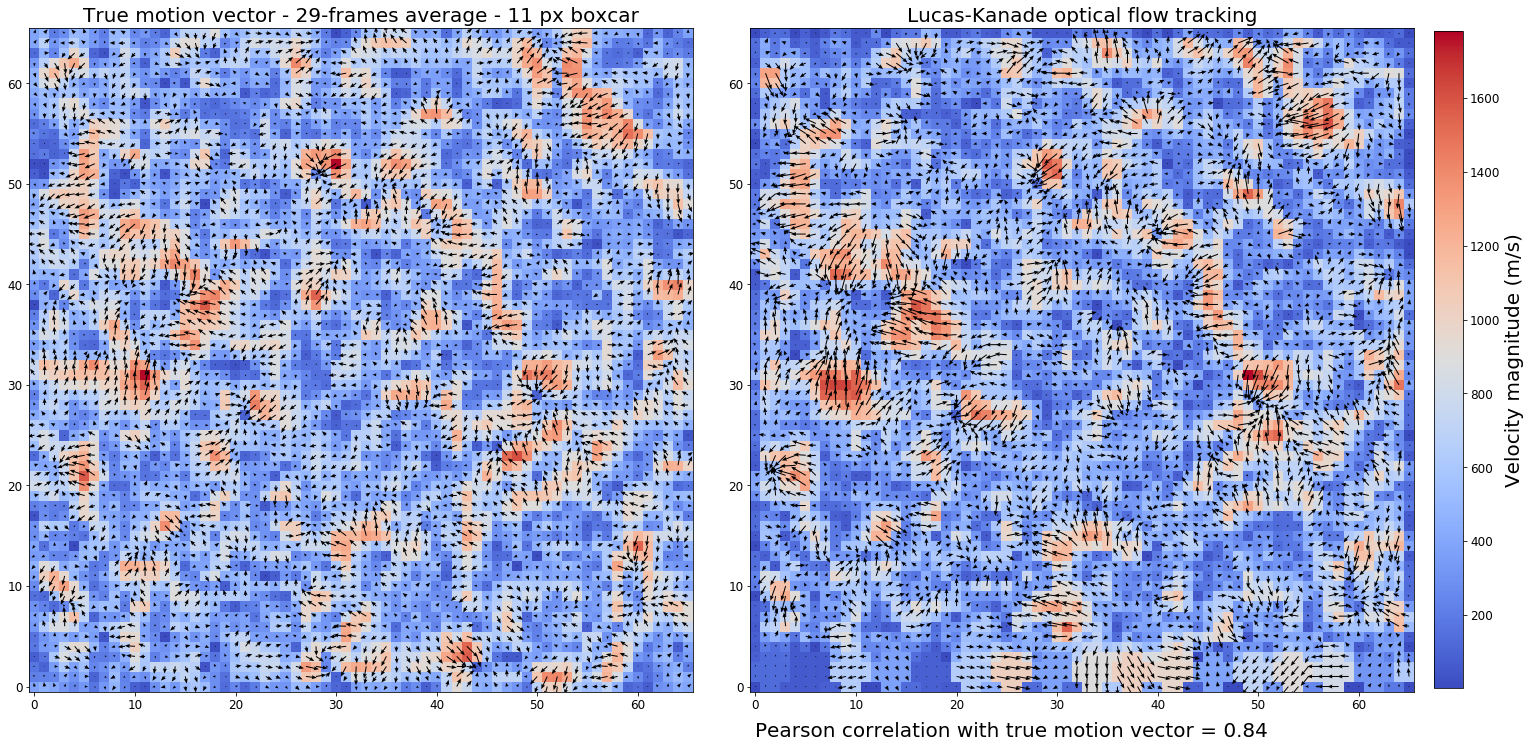

In [94]:
fig,axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 12))
im0 = axs[0].imshow(v_stein_sm_pad[2,...], origin='lower', cmap='coolwarm')
axs[0].quiver(v_stein_sm_pad[0,...], v_stein_sm_pad[1,...], units='xy', scale=1000, width=0.1, headwidth=4, headlength=5)
axs[0].set_title('True motion vector - 29-frames average - 11 px boxcar', fontsize=20)
pos1 = axs[1].imshow(dvmean_sm[2,...], origin='lower', cmap='coolwarm')
axs[1].quiver(-dvmean_sm[0,...], -dvmean_sm[1,...], units='xy', scale=0.1, width=0.1, headwidth=4, headlength=5)
axs[1].set_title('Lucas-Kanade optical flow tracking', fontsize=20)
axs[1].text(0, -5, 'Pearson correlation with true motion vector = {:2.2f}'.format(corr), fontsize=20)
cbar_ax = fig.add_axes([1.0, 0.12, 0.02, 0.76])
cbar = fig.colorbar(im0, cax=cbar_ax)
cbar.ax.set_ylabel('Velocity magnitude (m/s)', fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(datadir, 'DALI', 'compare_flow_map.png'), dpi=120)

# 